In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats
import pickle

from LS import *

# plotting parameters
mpl.rcParams['font.serif'] = "Times New Roman"
mpl.rcParams["figure.figsize"] = [3.25,3.25]
mpl.rcParams['axes.linewidth'] = 0.5
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['lines.markersize'] = 7
mpl.rcParams['lines.markeredgewidth'] = 1
mpl.rc('text', usetex='true') 
mpl.rc('font', family='serif') 

plt.rcParams.update({'font.size': 8, 'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsfonts}'})

mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams["axes.labelsize"] = 18
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['axes.titlesize'] = 18

d = 50                                # dimension of domain (number of columns of matrix A)
n = 100                               # number of samples (number of rows of matrix A)
x_init = np.random.normal(size=d)     # initial point for minimizer random walk
Delta = 1                             # L2 step length for minimizer random walk
T = 100                               # number of steps (horizon)
mu = 1                                # strong convexity parameter of LS objectives
L = 1                                 # smoothness parameter of LS objectives
x_0 = np.random.normal(size=d)        # initial point for SGD
sigma = 10                             # sample gradient variance bound
N = 100                               # number of trials for computing empirical average

In [2]:
A = matrix(n, d, mu, L)               # generate (n,d) matrix A with min. sing. val. sqrt(mu) and max sing. val. sqrt(L)
B = (norm(A, ord=2)**2)*Delta         # upper bound on gradient drift (L*Delta)

In [3]:
eta = eta_opt1(mu, L, sigma, Delta)         # asymptotically optimal step size for distance tracking error

In [4]:
print(Delta, sigma, L, eta, 1/(2*L))

1 10 1 0.2714417616594907 0.5


In [5]:
a1_LS = trckerr1trials(x_init, Delta, T, A, sigma, x_0, eta, N)    # distance tracking errors (N trials)
a2_LS = asymptbd1(mu, eta, sigma, Delta)                           # asymptotic bound (noise + drift)
a3_LS = opterr1(mu, eta, x_0, x_init, T) + a2_LS                   # guaranteed bound (optimization + noise + drift)

In [6]:
def NinetyFive_CI(data):
    a = 1.0 * np.array(data)
    m = np.mean(a)
    h = 2*np.std(a)
    return m-h, m, m+h

Text(19.042358246419674, 0.5, '$ \\mathbb{E} \\|x_t - x_t^\\star\\|^2$')

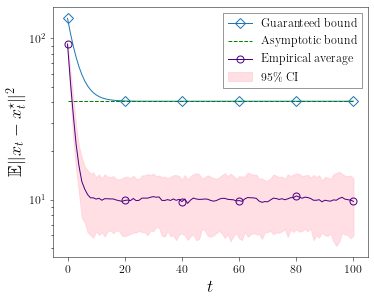

In [7]:
# set up plot area
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
fig.tight_layout(pad=1)

# 95% confidence interval data
m0 = [NinetyFive_CI(a1_LS[k]) for k in range(a1_LS.shape[0])]
m = np.stack(m0, axis=0)

# plot a1_LS (with 95% confidence interval), a2_LS, a3_LS
axes.semilogy(a3_LS, label='Guaranteed bound', color='tab:blue', linestyle='-', marker='D', markerfacecolor='none', markevery=int((T+1)/5))
axes.semilogy(a2_LS*np.ones(T+1), label='Asymptotic bound', color='green', linestyle='--')
fillcolor = 'pink'
linecolor = 'indigo'
axes.semilogy(m[:,1], color=linecolor, marker = 'o', markerfacecolor='none', markevery=int((T+1)/5), label='Empirical average')
axes.fill_between(np.arange(0,T+1), m[:,0], m[:,2], alpha=0.5,edgecolor=fillcolor, facecolor=fillcolor, label = '95\% CI')
axes.tick_params(width=.5)

# set up legend
leg = axes.legend(loc = 'best')
leg.get_frame().set_edgecolor('k')
leg.get_frame().set_linewidth(0.5)
leg.get_frame().set_boxstyle('Square', pad=0)

# label axes
plt.xlabel(r'$t$')
plt.ylabel(r'$ \mathbb{E} \|x_t - x_t^\star\|^2$')


In [8]:
with open('plot1_LS.p', 'wb') as f:
    pickle.dump([a1_LS, a2_LS, a3_LS], f)

In [9]:
def func1(eta, sigma, Delta, T):     # N trials of distance tracking error at horizon T as a function of eta, sigma, Delta, T
    return trckerr1trials(x_init, Delta, T, A, sigma, x_0, eta, N)[T]
def bdfunc1(eta, sigma, Delta, T):   # guaranteed bound on distance tracking error at horizon T as a function of eta, sigma, Delta, T
    return opterr1(mu, eta, x_0, x_init, T)[T] + asymptbd1(mu, eta, sigma, Delta)

In [10]:
x0 = np.linspace(.02,1/2,20)
x1 = np.linspace(.02,20,20)
x2 = np.linspace(.02,20,20)

s0 = np.array([func1(x, sigma, Delta, T) for x in x0])
s1 = np.array([func1(eta, x, Delta, T) for x in x1])
s2 = np.array([func1(eta, sigma, x, T) for x in x2])

r0 = np.array([bdfunc1(x, sigma, Delta, T) for x in x0])
r1 = np.array([bdfunc1(eta, x, Delta, T) for x in x1])
r2 = np.array([bdfunc1(eta, sigma, x, T) for x in x2])

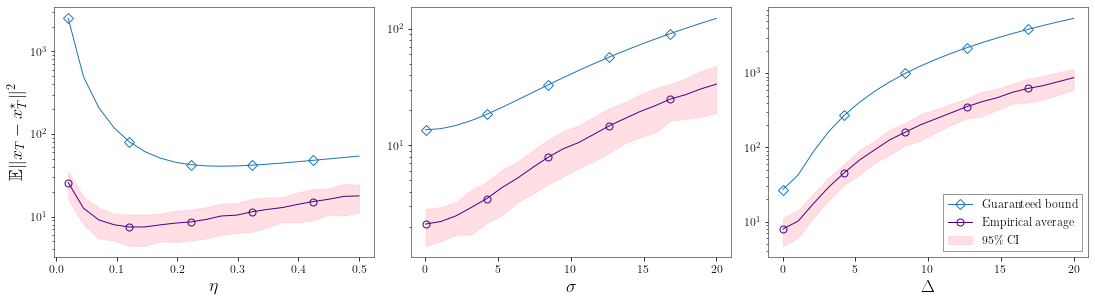

In [11]:
# set up plot area
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,4))
fig.tight_layout(pad=1)
axes[0].set_ylabel(r'$\mathbb{E}\|x_T - x_T^\star\|^2$') 
fillcolor = 'pink'
linecolor = 'indigo'

# stuff things into lists to access in a loop 
x1_LS = [x0,x1,x2]
s1_LS = [s0,s1,s2]
r1_LS = [r0,r1,r2]
xlabels = [r'$\eta$',r'$\sigma$',r'$\Delta$']

# plot each column 
for j in range(3):
    m = [NinetyFive_CI(s1_LS[j][k]) for k in range(s1_LS[j].shape[0])]
    m_j = np.stack(m, axis=0)
    
    # plot guaranteed bound and emperical values with 95% confidence interval
    axes[j].semilogy(x1_LS[j], r1_LS[j], color='tab:blue', marker='D', markerfacecolor='none', markevery=4, label = 'Guaranteed bound')
    axes[j].semilogy(x1_LS[j], m_j[:,1], color=linecolor, marker='o', markerfacecolor='none', markevery=4, label = 'Empirical average')
    axes[j].fill_between(x1_LS[j], m_j[:,0], m_j[:,2], alpha=0.5, edgecolor=fillcolor, facecolor=fillcolor, label = '95\% CI')
    
    # set axis labels and scale
    axes[j].set_xlabel(xlabels[j])
    plt.sca(axes[j])
    
# set up legend
leg = axes[2].legend(loc = 'best')
leg.get_frame().set_edgecolor('k')
leg.get_frame().set_linewidth(0.5)
leg.get_frame().set_boxstyle('Square', pad=0)


In [12]:
with open('plot2_LS.p', 'wb') as f:
    pickle.dump([x1_LS, s1_LS, r1_LS], f)

In [13]:
eta = eta_opt2(mu, L, sigma, B)   # asymptotically optimal step size for function gap tracking error

In [14]:
b1_LS = trckerr2trials(x_init, Delta, T, A, sigma, x_0, eta, mu, N)  # function gap tracking errors (N trials)
b2_LS = asymptbd2(mu, eta, sigma, B)                                 # asymptotic bound (noise + drift)
b3_LS = empopterr2bd(mu, eta, x_0, A, x_init, T) + b2_LS             # guaranteed bound

Text(19.042358246419674, 0.5, '$\\mathbb{E}[\\varphi_t(\\hat{x}_t) - \\varphi_t^\\star]$')

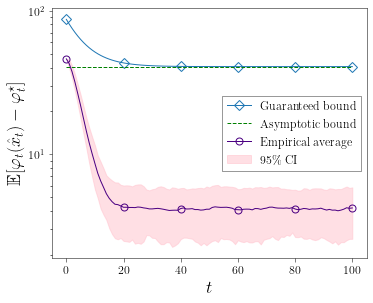

In [15]:
# set up plot area
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
fig.tight_layout(pad=1)

# 95% confidence interval data
m0 = [NinetyFive_CI(b1_LS[k]) for k in range(b1_LS.shape[0])]
m = np.stack(m0, axis=0)

# plot b1_LS (with 95% confidence interval), b2_LS, b3_LS
axes.semilogy(b3_LS, label='Guaranteed bound', color='tab:blue', linestyle='-', marker='D', markerfacecolor='none', markevery=int((T+1)/5))
axes.semilogy(b2_LS*np.ones(T+1), label='Asymptotic bound', color='green', linestyle='--')
fillcolor = 'pink'
linecolor = 'indigo'
axes.semilogy(m[:,1], color=linecolor, marker = 'o', markerfacecolor='none', markevery=int((T+1)/5), label='Empirical average')
axes.fill_between(np.arange(0,T+1), m[:,0], m[:,2], alpha=0.5,edgecolor=fillcolor, facecolor=fillcolor, label = '95\% CI')
axes.tick_params(width=.5)

# set up legend
leg = axes.legend(loc = 'best')
leg.get_frame().set_edgecolor('k')
leg.get_frame().set_linewidth(0.5)
leg.get_frame().set_boxstyle('Square', pad=0)

# label axes
plt.xlabel(r'$t$')
plt.ylabel(r'$\mathbb{E}[\varphi_t(\hat{x}_t) - \varphi_t^\star]$')


In [16]:
with open('plot3_LS.p', 'wb') as f:
    pickle.dump([b1_LS, b2_LS, b3_LS], f)

In [17]:
def func2(eta, sigma, Delta, T):     # N trials of function gap tracking error at horizon T as a function of eta, sigma, Delta, T
    return trckerr2trials(x_init, Delta, T, A, sigma, x_0, eta, mu, N)[T]
def bdfunc2(eta, sigma, Delta, T):   # guaranteed bound on function gap tracking error at horizon T as a function of eta, sigma, Delta, T
    return  empopterr2bd(mu, eta, x_0, A, x_init, T)[T] + asymptbd2(mu, eta, sigma, (norm(A, ord=2)**2)*Delta)

In [18]:
x00 = np.linspace(.02,1/2,20)
x11 = np.linspace(.02,20,20)
x22 = np.linspace(.02,20,20)

s00 = np.array([func2(x, sigma, Delta, T) for x in x00])
s11 = np.array([func2(eta, x, Delta, T) for x in x11])
s22 = np.array([func2(eta, sigma, x, T) for x in x22])

r00 = np.array([bdfunc2(x, sigma, Delta, T) for x in x00])
r11 = np.array([bdfunc2(eta, x, Delta, T) for x in x11])
r22 = np.array([bdfunc2(eta, sigma, x, T) for x in x22])

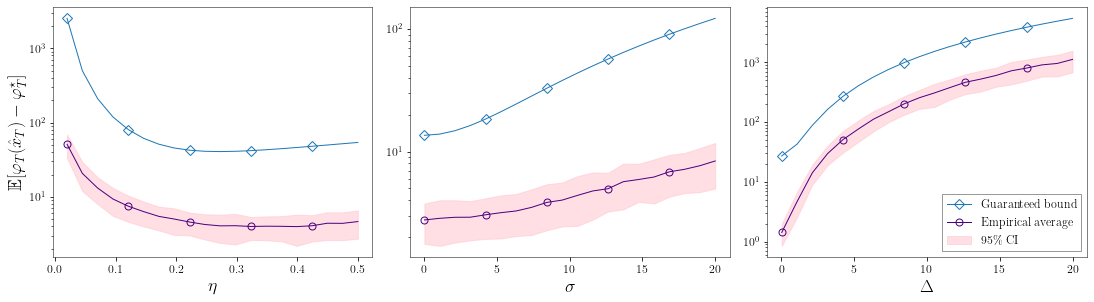

In [19]:
# set up plot area
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,4))
fig.tight_layout(pad=1)
fillcolor = 'pink'
linecolor = 'indigo'

# stuff things into lists to access in a loop 
x2_LS = [x00,x11,x22]
s2_LS = [s00,s11,s22]
r2_LS = [r00,r11,r22]
xlabels = [r'$\eta$',r'$\sigma$',r'$\Delta$']

# plot each column 
for j in range(3):
    m = [NinetyFive_CI(s2_LS[j][k]) for k in range(s2_LS[j].shape[0])]
    m_j = np.stack(m, axis=0)
        
    # plot guaranteed bound and emperical values with 95% confidence interval
    axes[j].semilogy(x2_LS[j], r2_LS[j], color='tab:blue', marker='D', markerfacecolor='none', markevery=4, label = 'Guaranteed bound')
    axes[j].semilogy(x2_LS[j], m_j[:,1], color=linecolor, marker='o', markerfacecolor='none', markevery=4, label = 'Empirical average')
    axes[j].fill_between(x2_LS[j], m_j[:,0], m_j[:,2], alpha=0.5, edgecolor=fillcolor, facecolor=fillcolor, label = '95\% CI')
    
    # set axis labels and scale
    axes[j].set_xlabel(xlabels[j])
    plt.sca(axes[j])

axes[0].set_ylabel(r'$\mathbb{E}[\varphi_T(\hat{x}_T) - \varphi_T^\star]$')    

# set up legend
leg = axes[2].legend(loc = 'best')
leg.get_frame().set_edgecolor('k')
leg.get_frame().set_linewidth(0.5)
leg.get_frame().set_boxstyle('Square', pad=0)


In [20]:
with open('plot4_LS.p', 'wb') as f:
    pickle.dump([x2_LS, s2_LS, r2_LS], f)